Basado en : https://www.kaggle.com/code/paulinan/bank-customer-segmentation/notebook

# Segmentación de clientes bancarios

En este núcleo realizaremos la segmentación de clientes de los bancos alemanes.  


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")

Leyendo los datos

In [3]:
data = pd.read_csv("/content/3.4.3 german_credit_data.csv")

Control visual de las primeras filas

In [4]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


Parece que la primera columna es simplemente un índice que podemos eliminar. Verificaremos cuántos valores faltantes hay en cada columna y de qué tipos de datos son.

In [5]:
data.drop(data.columns[0], inplace=True, axis=1)
print("Database has {} obserwations (customers) and {} columns (attributes).".format(data.shape[0],data.shape[1]))
print("Missing values in each column:\n{}".format(data.isnull().sum()))
print("Columns data types:\n{}".format(data.dtypes))

Database has 1000 obserwations (customers) and 9 columns (attributes).
Missing values in each column:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64
Columns data types:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


De 8 columnas, 2 contienen valores faltantes. Probablemente se trate de clientes que no tengan ninguna de estas dos cuentas.

Generalmente existen 3 variables numéricas y 5 categóricas.

Ahora, comprobaremos cuántos y cuáles son los valores posibles (únicos) en cada columna categórica.

In [6]:
n_unique = data.nunique()
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [7]:
print("Unique values in each categorical column:")
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Unique values in each categorical column:
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


**Análisis exploratorio de datos**

A continuación definiremos una función que generará gráficos para tres variables numéricas con estratificación por columna categórica seleccionada.

In [8]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

Al principio veamos los diagramas de dispersión de nuestras 3 variables numéricas estratificadas por sexo.

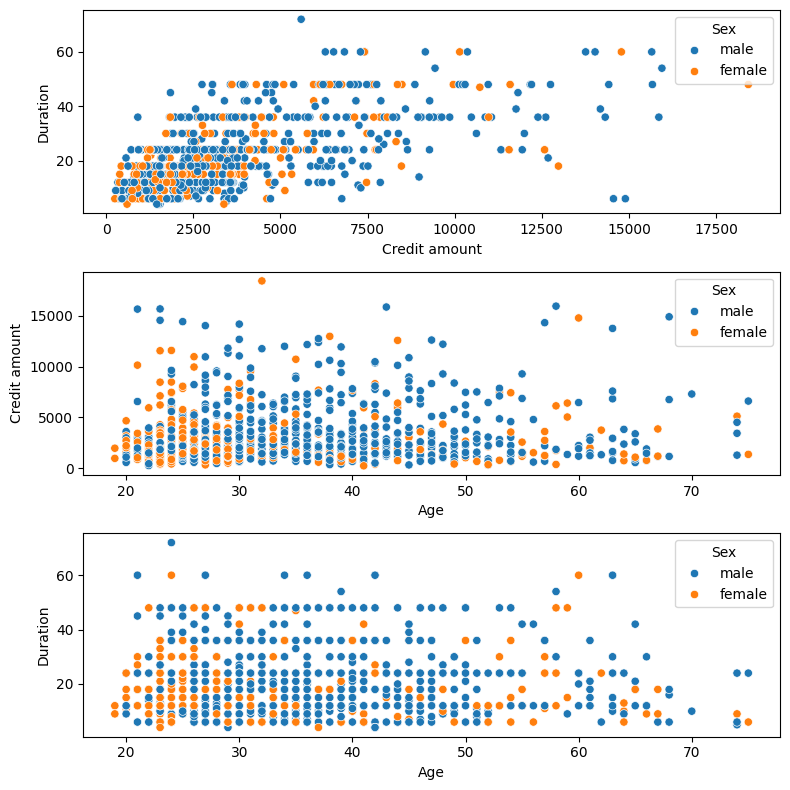

In [9]:
scatters(data, h="Sex")

La impresión general es que las mujeres tienden a ser más jóvenes que los hombres, sin embargo, el gráfico superior muestra que no hay una diferencia clara entre hombres y mujeres en términos de monto y duración del crédito. A partir de una inspección visual, parece que existe cierta correlación positiva entre la duración y el monto del crédito, lo que tiene sentido.

Comprobemos la correlación lineal entre el importe del crédito y la duración.

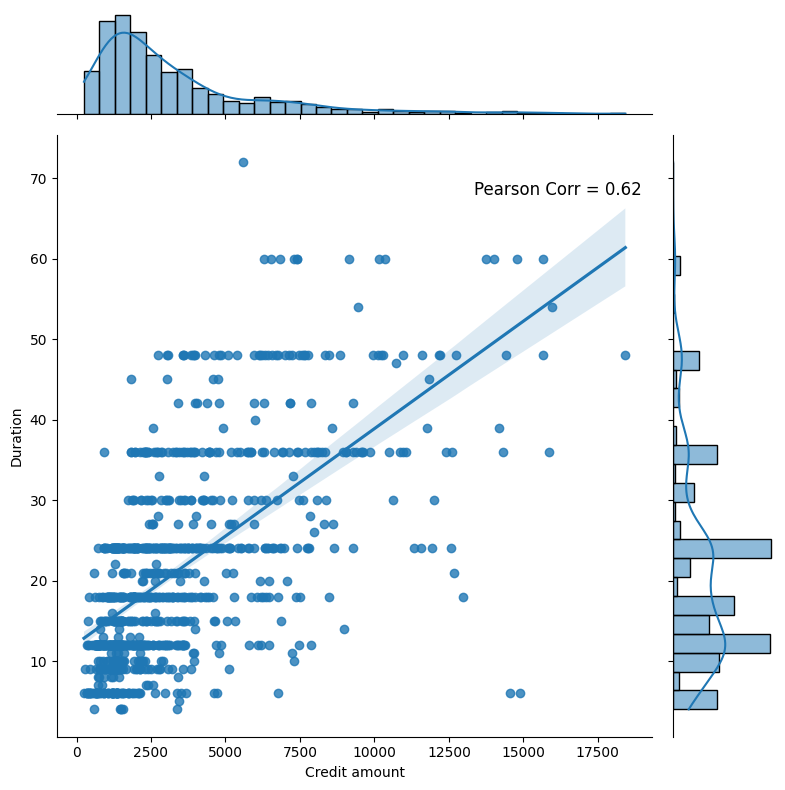

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Crear el jointplot
r1 = sns.jointplot(x="Credit amount", y="Duration", data=data, kind="reg", height=8)

# Calcular la correlación de Pearson
pearson_corr, _ = stats.pearsonr(data["Credit amount"], data["Duration"])

# Anotar el gráfico con la correlación de Pearson
r1.ax_joint.annotate(f"Pearson Corr = {pearson_corr:.2f}", xy=(0.7, 0.9), xycoords="axes fraction", fontsize=12)

# Mostrar el gráfico
plt.show()


El gráfico anterior muestra una correlación lineal con el valor de Pearson de 0,62 y un valor p muy pequeño. Esto tiene sentido porque, por lo general, las personas obtienen créditos más grandes por períodos más largos. A continuación analizaré gráficos de regresión lineal con varias categorizaciones.

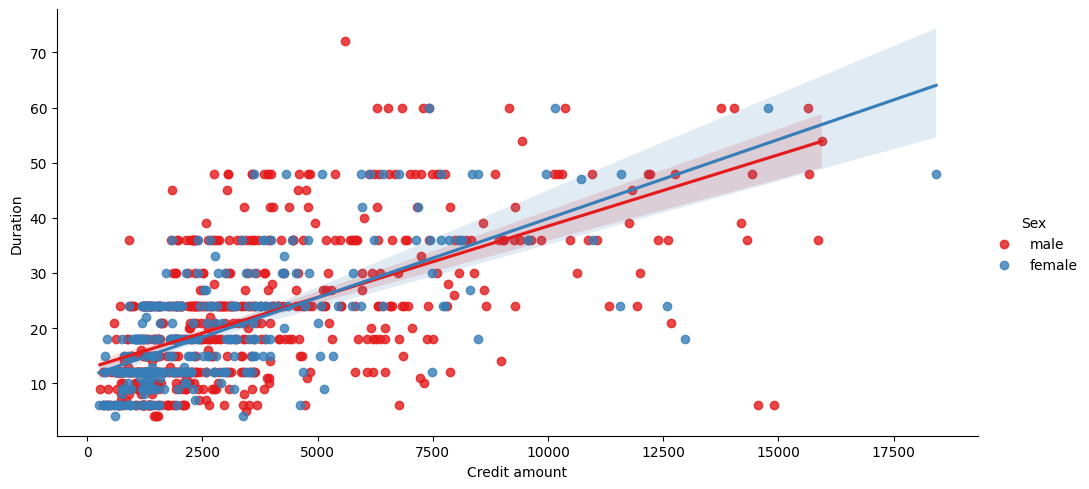

In [11]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=data, palette="Set1", aspect=2)
plt.show()

El gráfico anterior indica que no hay una diferencia significativa entre hombres y mujeres.

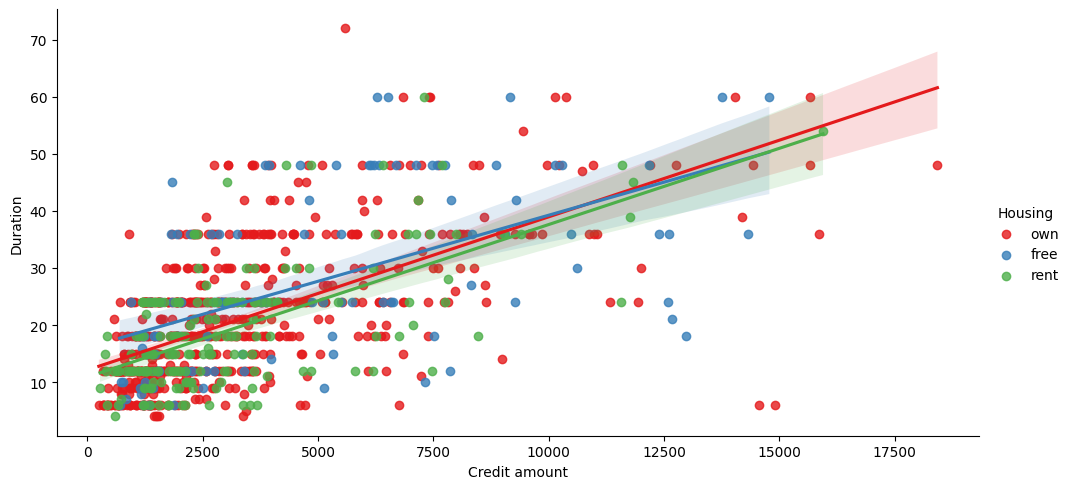

In [12]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=data, palette="Set1", aspect=2)
plt.show()

El gráfico anterior muestra de manera similar que no hay diferencias entre las categorías de vivienda.
A continuación mostraré el área de “negocios” donde se otorga la mayor cantidad de créditos.

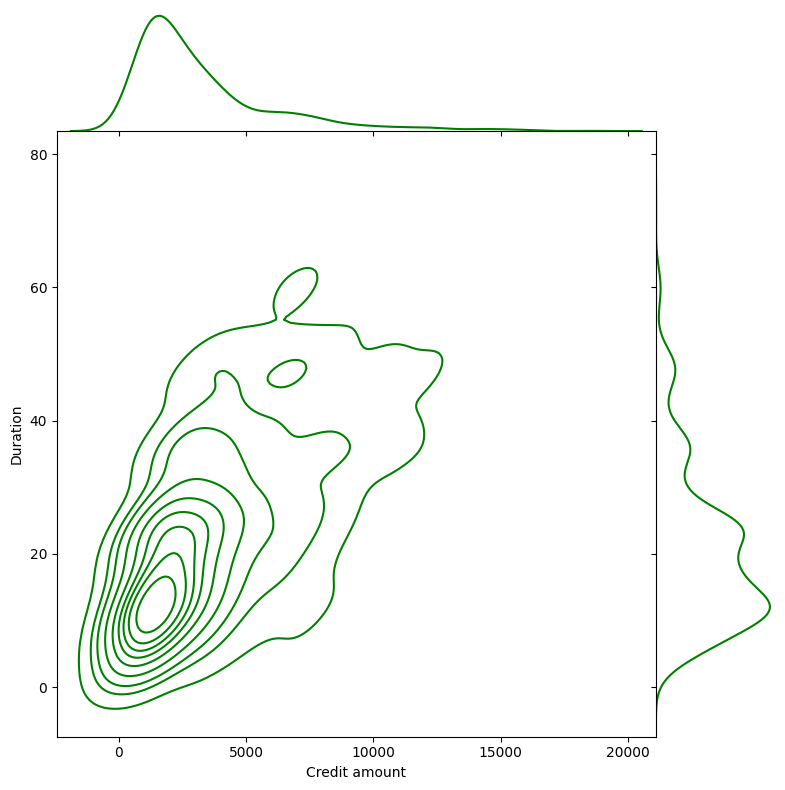

In [13]:
sns.jointplot(x="Credit amount", y="Duration", data=data, kind="kde", space=0, color="g", height=8)
plt.show()


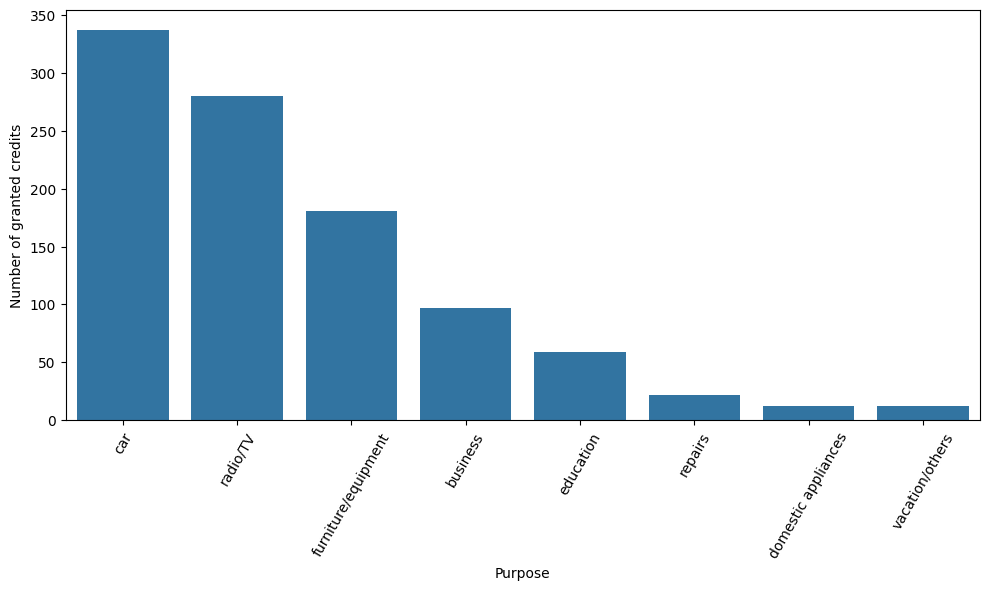

In [14]:
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Number of granted credits")
plt.tight_layout()

El diagrama de barras anterior muestra cuántos créditos se otorgaron para diversos fines. La mayoría de los créditos se concedieron para automóviles y radio/TV.

Ahora generaré diagramas de caja para un análisis detallado de variables categóricas.

In [15]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

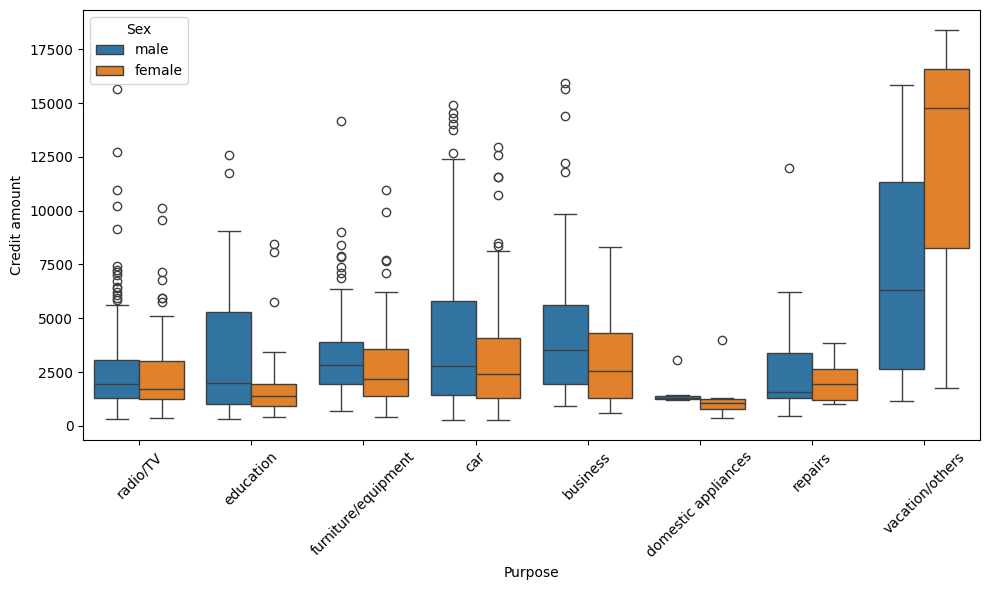

In [16]:
boxes("Purpose","Credit amount","Sex")

El gráfico anterior muestra que las cantidades más grandes se toman para vacaciones/otros, y las más pequeñas para electrodomésticos. La mayoría de ellos tienen valores atípicos en la parte superior de los cuadros (cantidades más altas). En la mayoría de los casos no hay diferencia entre hombres y mujeres, a pesar de la categoría vacaciones/otros. Pero hay que recordar que hubo muy pocos créditos concedidos en esta categoría.

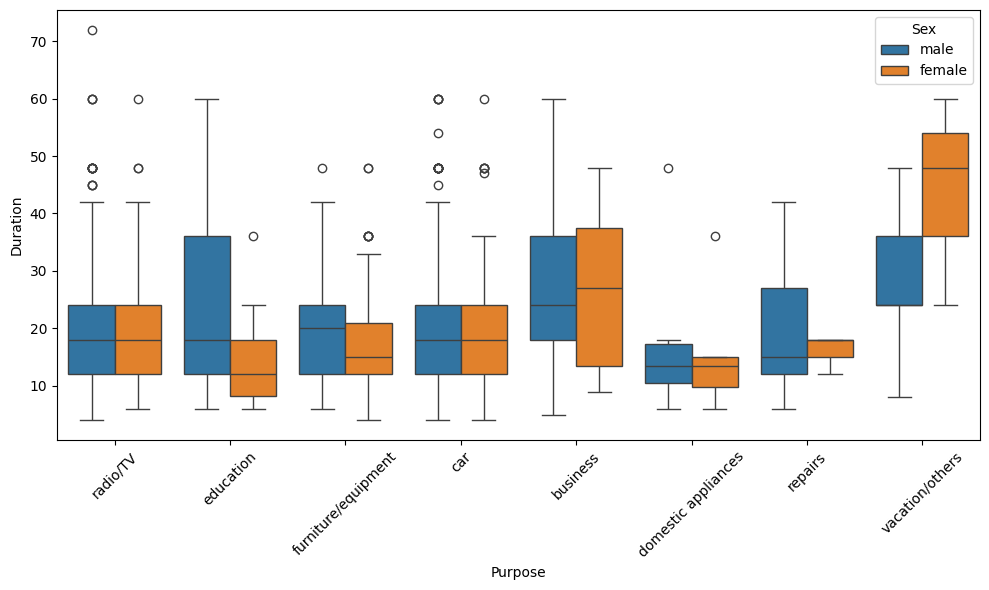

In [17]:
boxes("Purpose","Duration","Sex")

El diagrama de caja anterior indica que, en general, no hay diferencia en la duración del crédito entre hombres y mujeres. No podemos ver tampoco una tendencia clara entre categorías con observaciones de que la duración más corta es para los electrodomésticos. Tiene sentido ya que está de acuerdo con las ideas del gráfico anterior (cantidad de crédito): en esta categoría se encuentran las cantidades más bajas de créditos.

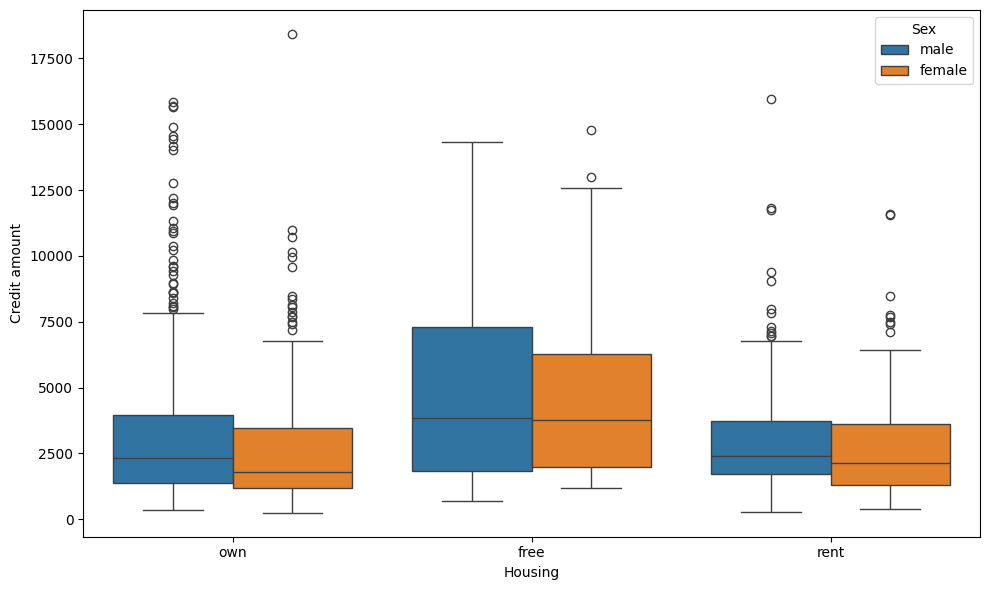

In [18]:
boxes("Housing","Credit amount","Sex",r=0)

En términos de categoría de vivienda, no hay gran diferencia a pesar de que las personas que tienen una vivienda “gratuita” tienden a solicitar montos de crédito ligeramente mayores.

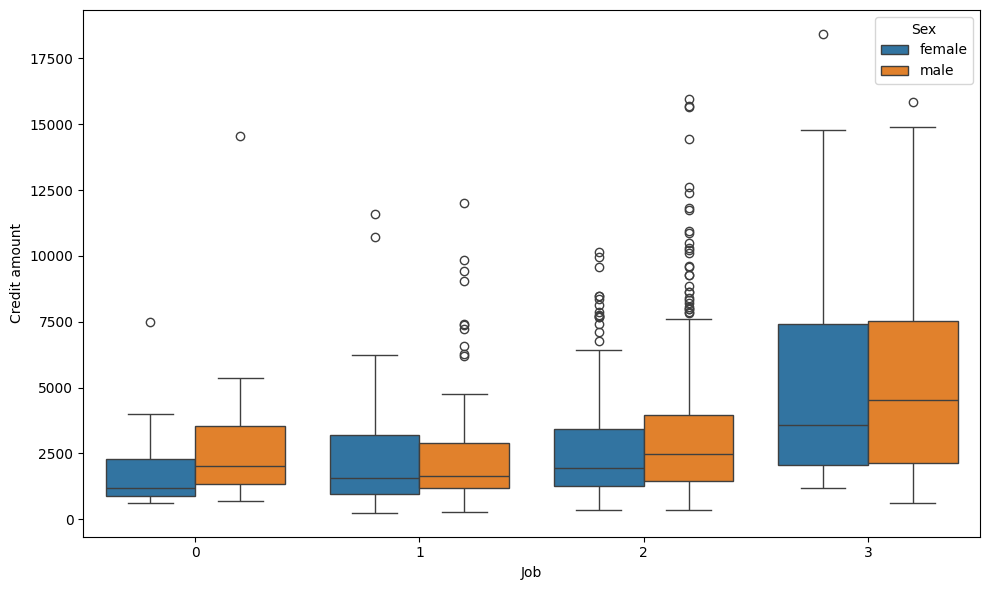

In [19]:
boxes("Job","Credit amount","Sex",r=0)

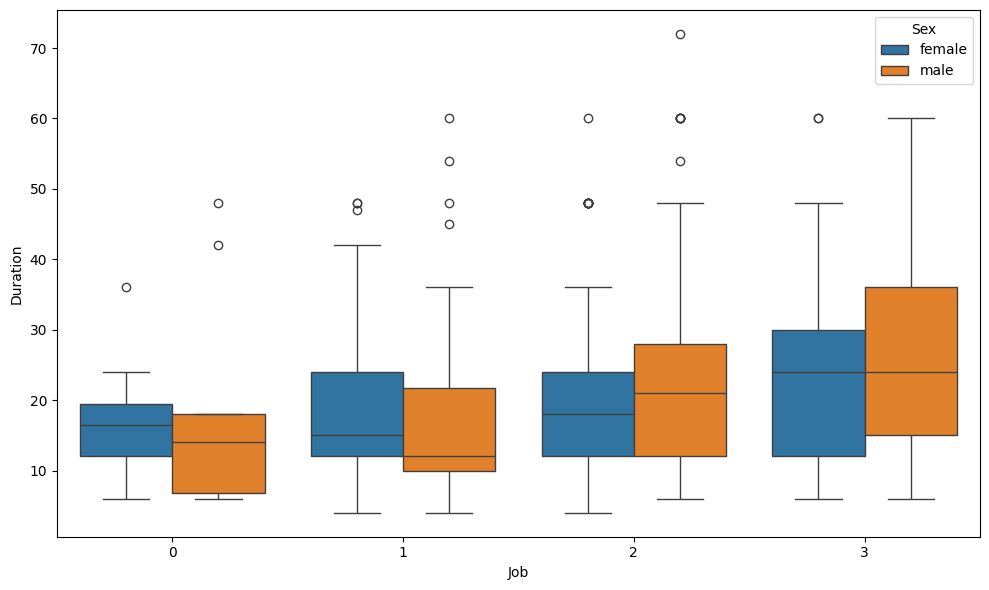

In [20]:
boxes("Job","Duration","Sex",r=0)

En términos de categoría laboral, una vez más no hay diferencia entre hombres y mujeres, pero podemos ver que la categoría laboral 3 tiende a aceptar montos de crédito mayores por mayor duración.



Text(0.5, 0, 'Age')

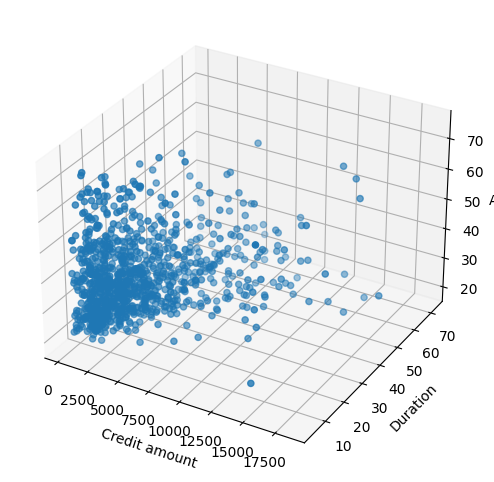

In [21]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Credit amount"], data["Duration"], data["Age"])
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

**Agrupación con KMeans**

Para la agrupación, crearé un subconjunto que contenga solo variables numéricas (edad, monto del crédito, duración).

In [22]:
#Selecting columns for clusterisation with k-means
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

Se creará una función que traza tres histogramas, uno para cada variable.

In [23]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

Veamos los histogramas

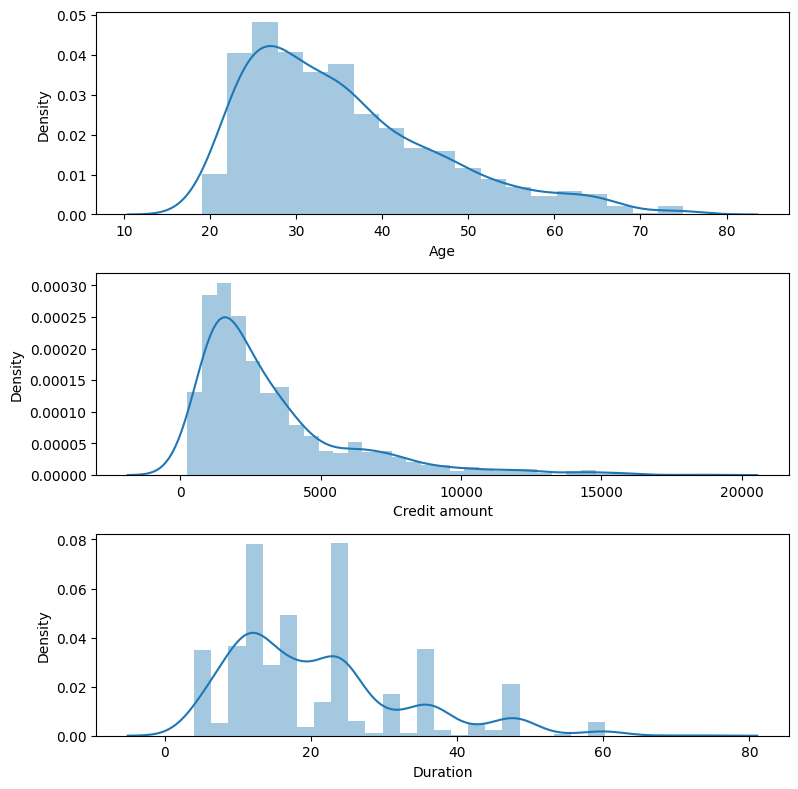

In [24]:
distributions(cluster_data)

Podemos ver que las distribuciones están sesgadas hacia la derecha. Para obtener mejores resultados debemos eliminar la asimetría mediante transformación logarítmica. Después de eso veamos cómo quedan.

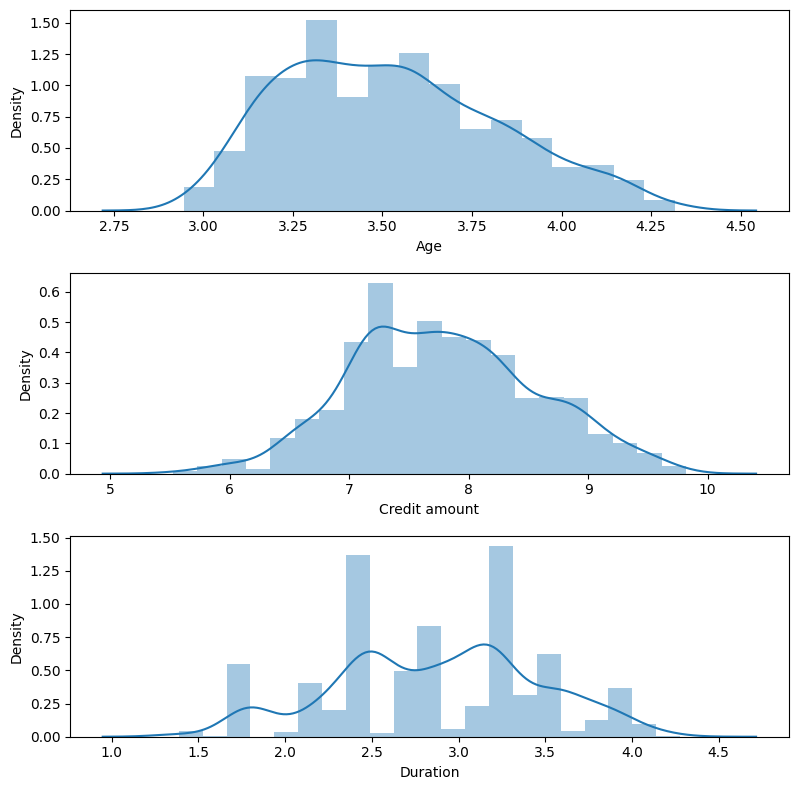

In [25]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

De hecho, se ha eliminado la asimetría.

El siguiente paso será centrar y escalar las variables; esto lo requiere el algoritmo KMeans. Usaremos para eso un StandardScaler de la biblioteca sklearn.

In [26]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

Veamos cómo cambia la inercia para varios grupos.

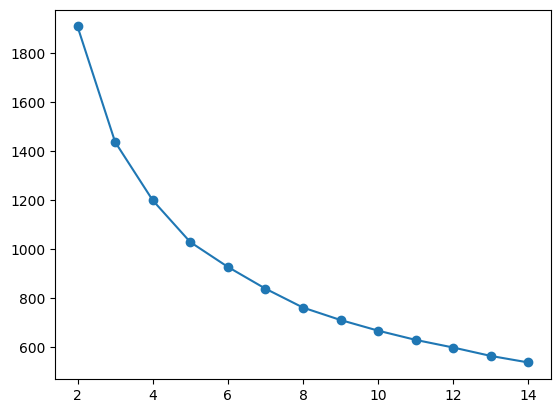

In [27]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')

El gráfico anterior muestra que la inercia disminuye a medida que aumenta el número de grupos.

Este método permite evaluar las separaciones de los conglomerados y ajustar cada observación en su propio conglomerado. Cuanto más alto sea el puntaje, mejor. También realizaremos este análisis para varias semillas.

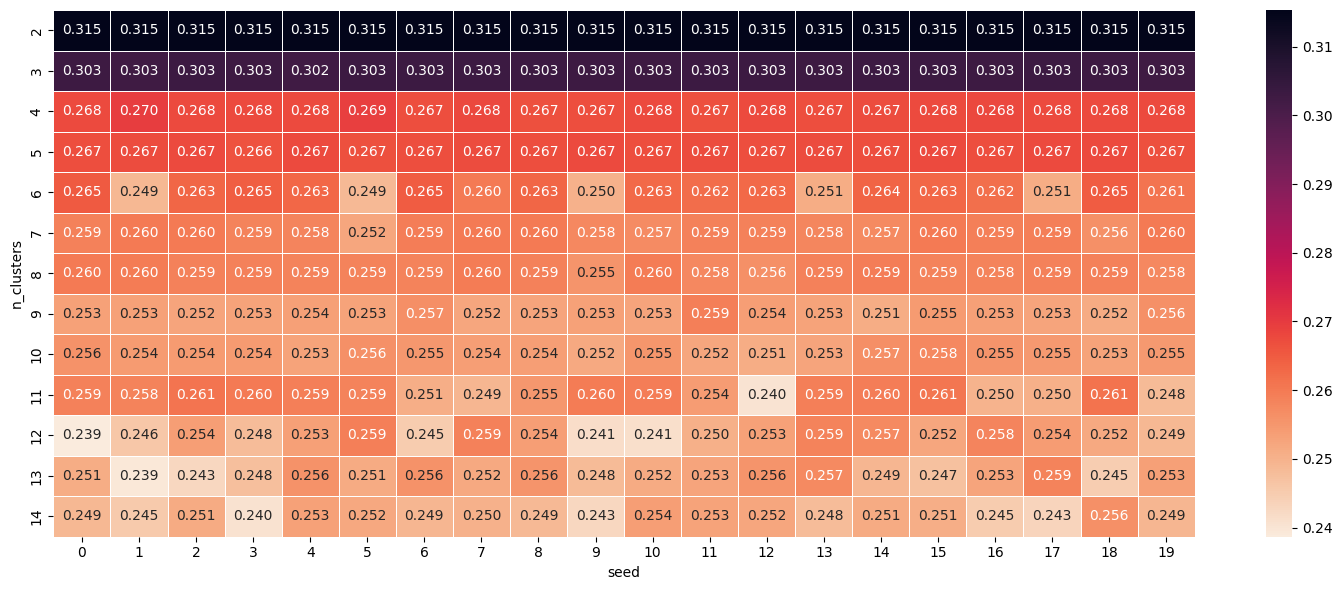

In [28]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

El mapa de calor anterior muestra puntuaciones de Silhouette para varias combinaciones de estado aleatorio y número de grupos. Los puntajes más altos son para racimos 2 y 3 y son relativamente insensibles a la semilla.

Elegiremos 3 grupos para obtener más información sobre los datos.

In [29]:
kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

A continuación, crearemos un gráfico de Silhouette para 3 grupos para representar visualmente el ajuste de cada punto dentro de su propio grupo (código modificado del documento scikit-learn).

For n_clusters = 3  and seed = 19 
The average silhouette_score is : 0.30255813750380023


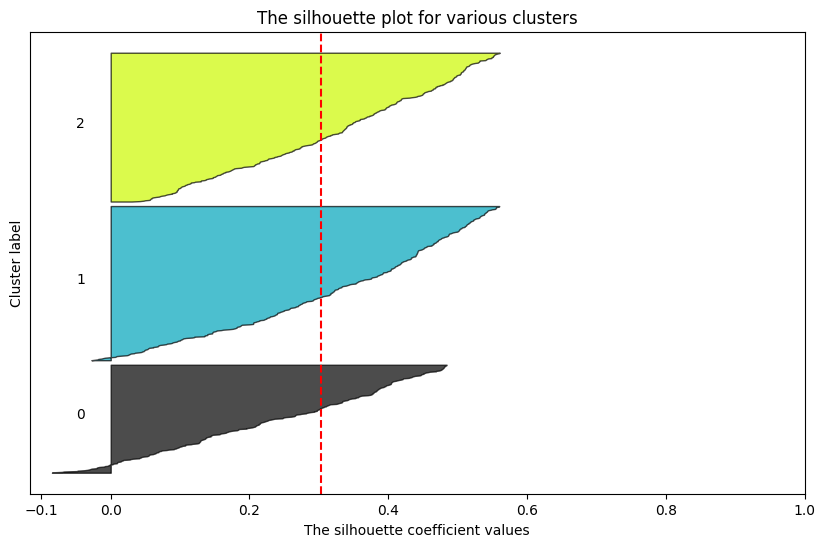

In [30]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=3, random_state=1)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("For n_clusters =", 3," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(3):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([])
ax1.set_title("The silhouette plot for various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

Definiremos una función que muestre grupos en el diagrama de dispersión.

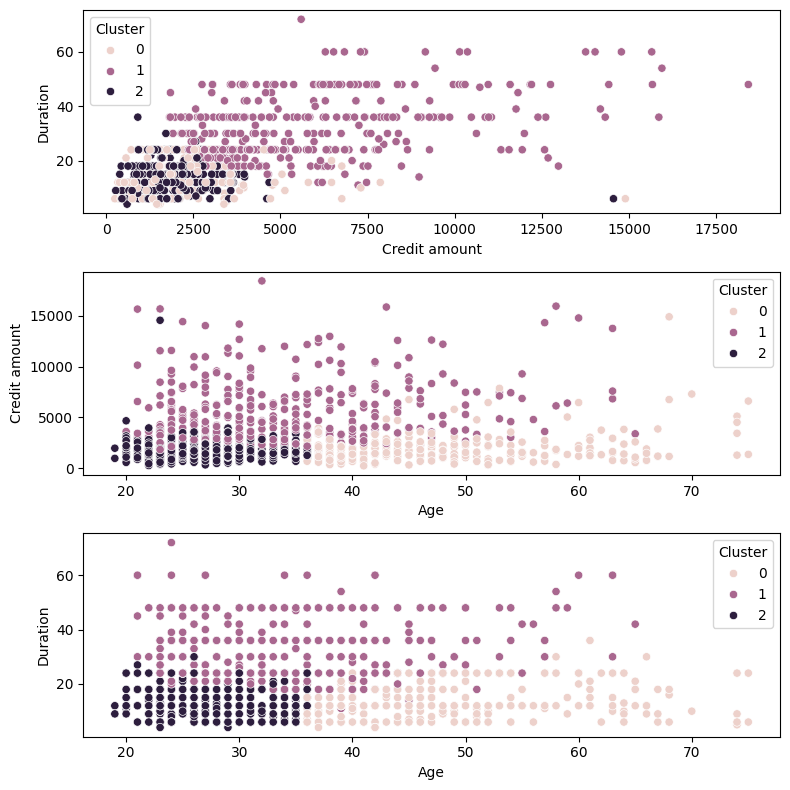

In [31]:
scatters(clustered_data, 'Cluster')

Los gráficos de arriba muestran tres grupos creados. Dos de los inferiores muestran una separación de grupos relativamente clara, pero no es tan evidente en el superior.

Generaremos ahora un gráfico de mapa de calor para facilitar la interpretación empresarial de la segmentación de clientes.

In [32]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,48.5,1970.3,13.9
1,34.0,5665.4,32.2
2,27.7,1736.3,14.3


Grupo 0: media más baja del monto del crédito, duración corta, clientes de mayor edad

Grupo 1: cantidad media alta de crédito, larga duración, clientes de mediana edad

Grupo 2: media más baja del importe del crédito, corta duración, clientes jóvenes